# Chicago crime profile

Here we calculate supporting data and timeseries to summarize the crime profile in the city of Chicago. Much of the visualization will be written in D3, though there will be some visualization here for investigations or validation. 

We profile crime in the city by looking at the "Crime Gini". This coefficient measures how much of the crime affects certain people over others, i.e. the crime inequality. This will also be broken out by crime type.

This coefficient will be measured through time to elucidate trends in crime data, as well as put in context of how earnings distributions (a standard Gini coefficient) has changed through the years. We also will produce neighborhood stories, where parts of the city are crossed against the trends observed in the data, to see which areas have been doing well in terms of crime and income, and which have been doing poorly.

Once central dataframe of interest here is one whose columns are the important attributes, such as crime type, and whose index is dimensioned on neighborhood x year. The other central dataframe here is one keyed on month, whose features are Chicago-wide values, like gini coefficients, total crime, or total population.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## Helper functions to be migrated

In [2]:
def multi_timeseries_explore_plot(df_ts, ylabel = None, title = None, cols_per_plot = 16):
    for i in range(len(df_ts.columns)//cols_per_plot + 1):
        cols_offset = cols_per_plot * i
        cols_to_plot = range(cols_offset,  min(len(df_ts.columns), cols_offset + cols_per_plot))
        df_ts[df_ts.columns[cols_to_plot]].plot().legend(bbox_to_anchor=(1, 1.05))
        if title:
            plt.title(title)
        if ylabel:
            plt.ylabel(ylabel)
            
def get_lorenz_curve(values, weights):
    """
    Return lorenz curve for values associated with weights population. 
    The first element of a tuple entry is the number of people associated with the point
    The second element is the value
    """
    lorenz_unnormalized = sorted(zip(weights, values), key = lambda x: x[1])
    total_weight = sum(map(lambda row: row[0], lorenz_unnormalized))
    total_weighted_value = sum(map(lambda row: row[0] * row[1], lorenz_unnormalized))
    return np.cumsum([ (x[0] / total_weight, x[0] * x[1] / total_weighted_value) for x in lorenz_unnormalized ], axis = 0)
    
def gini(values, weights):
    """
    Return gini coefficient for values associated with weights population. 
    """
    lorenz_curve = get_lorenz_curve(values, weights)
    # width is how far horizontally we have indexed, height is how far along the vertical axis
    width, height, area = 0, 0, 0
    for point in lorenz_curve:
        area += (point[0] - width)*height + (point[0] - width)*(point[1] - height) / 2
        height = point[1]
        width = point[0]
    fair_area = height * width / 2.
    return (fair_area - area) / fair_area

def pct_of_crime_in_top_pct_ppl(lorenz_curve, pct_ppl):
    """
    Return percent of crime in top X percent of population (i.e. of those in most intense circumstances)
    Calculated as 1 - lorenz curve(1 - top pct to consider)
    """
    # TODO: interpolate between left and right matches
    return 1 - lorenz_curve[np.searchsorted(lorenz_curve[:,0], 1 - pct_ppl), 1]

## City population

Here we read in the neighborhood populations through time, in addition to the Chicago totals, from a previous analysis / notebook. Note that in that analysis we used full-sampling census data (2000 and 2010) combined with select higher uncertainty but more coincident data from 2008 to present. By interpolating this data we obtained our monthly population timeseries.

While the aggregate population appears relatively constant since 2008, there is variation at the neighborhood level.

In [3]:
neighb_population = pd.read_csv('./data/rob_paral_combined_monthly.csv')[[
    'neighborhood', 
    'time',
    'Total_demographic', 
    'Not Hispanic or Latino: Asian alone',
    'Not Hispanic or Latino: Black or African American alone',
    'Hispanic or Latino',
    'Not Hispanic or Latino: White alone',
    'Not Hispanic or Latino: Other'
]].rename(columns = {
    'Total_demographic'                                       : 'population', 
    'Not Hispanic or Latino: Asian alone'                     : 'asian',
    'Not Hispanic or Latino: Black or African American alone' : 'black',
    'Hispanic or Latino'                                      : 'latino',
    'Not Hispanic or Latino: White alone'                     : 'white',
    'Not Hispanic or Latino: Other'                           : 'other'
})

neighb_pct_population = neighb_population.drop(['neighborhood', 'time', 'population'], axis = 1)\
    .div(neighb_population['population'], axis = 0)
neighb_pct_population[['neighborhood', 'time']] = neighb_population[['neighborhood', 'time']]
    
neighb_population['time'] = pd.to_datetime(neighb_population['time']).dt.to_period('M')
neighb_pct_population['time'] = pd.to_datetime(neighb_pct_population['time']).dt.to_period('M')

In [4]:
neighb_population.head()

,neighborhood,time,population,asian,black,latino,white,other
0,ROGERS PARK,2000-06,63484.0,4063.000000,18767.000000,17639.00000,20170.000000,2845.000000
1,ROGERS PARK,2000-07,63393.5,4061.583333,18712.354167,17593.03125,20192.020833,2834.510417
2,ROGERS PARK,2000-08,63303.0,4060.166667,18657.708333,17547.06250,20214.041667,2824.020833
3,ROGERS PARK,2000-09,63212.5,4058.750000,18603.062500,17501.09375,20236.062500,2813.531250
4,ROGERS PARK,2000-10,63122.0,4057.333333,18548.416667,17455.12500,20258.083333,2803.041667


In [5]:
city_population = neighb_population.groupby(['time']).sum().reset_index()

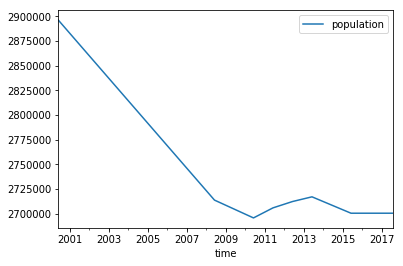

In [6]:
city_population.set_index('time')[['population']].plot()
plt.show()

In [7]:
neighb_population.head()

,neighborhood,time,population,asian,black,latino,white,other
0,ROGERS PARK,2000-06,63484.0,4063.000000,18767.000000,17639.00000,20170.000000,2845.000000
1,ROGERS PARK,2000-07,63393.5,4061.583333,18712.354167,17593.03125,20192.020833,2834.510417
2,ROGERS PARK,2000-08,63303.0,4060.166667,18657.708333,17547.06250,20214.041667,2824.020833
3,ROGERS PARK,2000-09,63212.5,4058.750000,18603.062500,17501.09375,20236.062500,2813.531250
4,ROGERS PARK,2000-10,63122.0,4057.333333,18548.416667,17455.12500,20258.083333,2803.041667


## City median income



In [8]:
rob_paral_income_raw = pd.read_csv('./data/rob_paral_combined_monthly.csv')

In [9]:
income_cols = [ col for col in rob_paral_income_raw.columns if '$' in col ]
income_cols

['Less than $10,000',
 '$10,000 to $14,999',
 '$15,000 to $19,999',
 '$20,000 to $24,999',
 '$25,000 to $29,999',
 '$30,000 to $34,999',
 '$35,000 to $39,999',
 '$40,000 to $44,999',
 '$45,000 to $49,999',
 '$50,000 to $59,999',
 '$60,000 to $74,999',
 '$75,000 to $99,999',
 '$100,000 to $124,999',
 '$125,000 to $149,999',
 '$150,000 to $199,999',
 '$200,000 or more']

In [10]:
def get_number_from_income_name(col):
    # just assign numbers for sake of median calc -- these will not affect median
    if 'Less' in col and '$10,000' in col:
        return 5000
    elif '$200,000' in col:
        return 250000 
    else: # this normalization will matter for median
        numbers = [ int(num) for num in col.replace(',', '').replace('$', '').split(' to ') ]
        return int(np.average(numbers) + 0.5)
        
income_col_number_map = { col : get_number_from_income_name(col) for col in income_cols }

In [11]:
def get_median_income_snap(row, num_map, num_cols):
    # first index of tupple is the percentile of population, second is the amount
    
    count_amts = sorted([ (row[col], num_map[col]) for col in num_cols ], key = lambda x: x[1])
    total_count = np.nansum([x[0] for x in count_amts])
    pct_amts = [ (x[0]/total_count, x[1]) for x in count_amts ]
    
    # find the two elements contributing to the med
    lower_cumulative_amt = pct_amts[0]
    upper_cumulative_amt = (pct_amts[0][0] + pct_amts[1][0], pct_amts[1][1]) # just for good practice...
    for x in pct_amts[1:]:
        upper_cumulative_amt = (x[0] + lower_cumulative_amt[0], x[1])
        if upper_cumulative_amt[0] > 0.5:
            break
        lower_cumulative_amt = upper_cumulative_amt
    
    # linear interpolation of median
    slope = (upper_cumulative_amt[1] - lower_cumulative_amt[1]) / (upper_cumulative_amt[0] - lower_cumulative_amt[0])
    
    return slope*(0.5 - lower_cumulative_amt[0]) + lower_cumulative_amt[1]

In [12]:
neighb_incomes = rob_paral_income_raw[['neighborhood', 'time'] + income_cols].copy()

In [13]:
neighb_incomes['median_income'] = \
    neighb_incomes.apply(get_median_income_snap, args = (income_col_number_map, income_cols), axis = 1)

In [14]:
neighb_incomes['time'] = pd.to_datetime(neighb_incomes['time']).dt.to_period('M')

### City of Chicago aggregates

In a separate dataframe lets calculate the city of chicago median income

In [15]:
chicago_incomes = neighb_incomes.drop(['neighborhood', 'median_income'], axis = 1).groupby('time').sum().reset_index()
chicago_incomes['median_income'] = \
    chicago_incomes.apply(get_median_income_snap, args = (income_col_number_map, income_cols), axis = 1)
chicago_incomes['neighborhood'] = 'CITY OF CHICAGO'

## Quick look at median incomes

First lets take a look at the Chicago median income, then the break-out by neighorhood

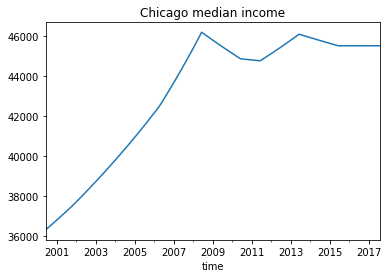

In [16]:
chicago_incomes.set_index('time')['median_income'].plot(title = 'Chicago median income')

plt.show()

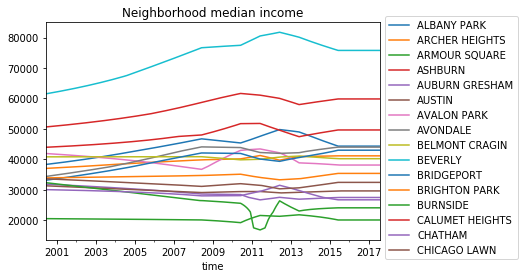

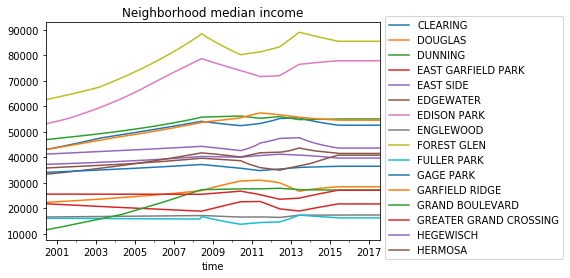

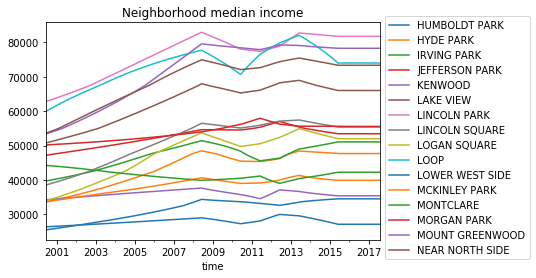

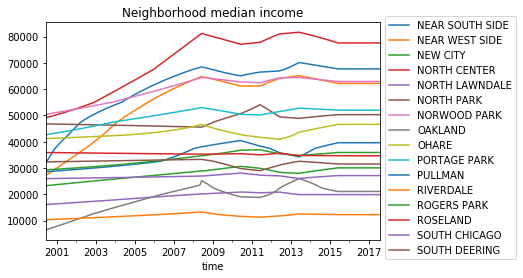

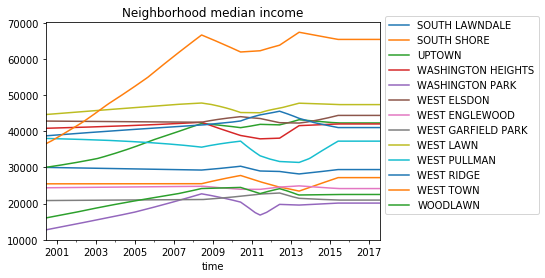

In [17]:
median_incomes_time = neighb_incomes\
    .reset_index()\
    .pivot(index = 'time', columns = 'neighborhood', values = 'median_income')
    
multi_timeseries_explore_plot(median_incomes_time, title = 'Neighborhood median income')

plt.show()

## Crime summaries

Here we produce the timeseries of crimes and crimes per person for each crime type, and how they have changed through time. With this data in hand, we can calculate the crime Gini coefficient through time.

### Severity index

Lets calculate the "severity index" based off of the criminal sentencing of crimes as studied in http://convictions.smartchicagoapps.org/#intro

In [18]:
# Use the median sentence as a proxy for severity of a crime
def min_sent_to_severity_index(mean_sent, median_sent, min_sent, max_sent):
    return median_sent

In [19]:
crime_severity = pd.DataFrame(
    pd.read_csv('./data/parsed_convictions_minsent.csv').set_index('iucr')\
        .apply(lambda row: min_sent_to_severity_index(*row), axis = 1)
)
crime_severity.columns = ['severity_index']

In [20]:
crime_severity.head()

,severity_index
iucr,
0110,22.0
0115,30.0
0130,7.0
0141,3.0
0142,3.0


In [21]:
crime_severity_dict = crime_severity.to_dict()['severity_index']
crime_severity_dict = { str(key).zfill(4) : crime_severity_dict[key] for key in crime_severity_dict }

# See below investigation why apply avg to 0460 and 0486
# Note that in the native data 0486 doesn't exist and instead 0486 is mapped to 0480 -- we don't want this
crime_severity_dict['0486'] = crime_severity_dict['0460']

In [22]:
crime_severity['severity_index'].min()

0.0

In [23]:
def get_severity(iucr, severity_dict):
    iucr_for_join = str(iucr).zfill(4)
    first_try = iucr_for_join
    second_try = iucr_for_join[:3] + '0'
    third_try = iucr_for_join[:2] + 'XX'
    if first_try in severity_dict:
        return severity_dict[first_try]
    elif second_try in severity_dict:
        return severity_dict[second_try]
    elif third_try in severity_dict:
        return severity_dict[third_try]
    else:
        return np.nan

In [24]:
individual_crimes = pd.read_csv('./data/cleaned_crimes.csv')

In [25]:
individual_crimes['time'] = pd.to_datetime(individual_crimes['date'], format = '%m/%d/%Y %I:%M:%S %p')\
    .dt.to_period('M')

In [26]:
individual_crimes['severity'] = individual_crimes['iucr'].map(lambda iucr: get_severity(iucr, crime_severity_dict))

### FYI: What is that Jump in 2003 and why treat 0460 and 0486 the same?

Upon a closer look, it appears there's a big spike in Simple Battery in 2003. This is likely due to reporting crimes differently. Drilling deeper, the rise in IUCR 0486 (Simple domestic battery) is the driver here. It appears that in 2002, there became a distinction between _battery_ (IUCR 0460) and _domestic battery_ (0486), the former having a lower median sentence than the latter.

Note that due to the 1 year rolling sums to avoid seasonality, this is likely due to a change in reporting in 2002, which is only fully incorporated by EOY 2002.

In [27]:
battery_iucr = individual_crimes[individual_crimes['crime_description'] == 'Simple Battery']\
    .groupby(['year', 'iucr'])[['date']]\
    .count()\
    .rename(columns = {'date' : 'crime_count'})

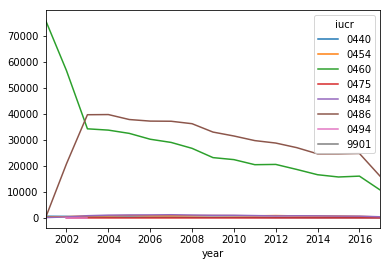

In [28]:
battery_iucr.reset_index().pivot(index = 'year', columns = 'iucr', values = 'crime_count').plot()

plt.show()

#### Filling in crimes that didn't get tagged with severity

It looks like almost entirely the crimes not tagged were miscellanous small offenses. Essentially irrelevant crimes, when considering things like battery, larceny, murder, etc.

There are a couple categories that don't seem to be getting tagged that are important -- but note that this is less than 1 in 2000 of overall crimes and should not impact our results significantly.

To handle these, we will apply the mean sentencing from their FBI code crime category.

In [29]:
individual_crimes[individual_crimes['severity'].isnull()].groupby('crime_description')\
    .agg(['count', 'sum'])['arrest']\
    .rename(columns = {'count' : 'crime_count', 'sum' : 'arrests_count'})

,crime_count,arrests_count
crime_description,,
Criminal Sexual Abuse,819,134.0
Disorderly Conduct,26,14.0
Liquor License,13746,13622.0
Misc Non-Index Offense,111047,47670.0
Simple Battery,1,1.0
Weapons Violation,2361,1764.0


In [30]:
mean_crime_severity_by_descr = individual_crimes\
    .groupby('crime_description')\
    .mean()[['severity']]\
    .rename(columns = {'severity' : 'mean_severity'})\
    .reset_index()

In [31]:
mean_crime_severity_by_descr

,crime_description,mean_severity
0,Aggravated Assault,1.500000
1,Aggravated Battery,0.887719
2,Arson,1.086683
3,Burglary,0.458882
4,Criminal Sexual Abuse,0.863980
5,Criminal Sexual Assault,6.830838
6,Disorderly Conduct,0.237044
7,Drug Abuse,0.324513
8,Embezzlement,0.200000
9,Forgery & Counterfeiting,0.200000


In [32]:
mean_severity = pd.merge(individual_crimes[['crime_description']], 
                         mean_crime_severity_by_descr,
                         on = 'crime_description')

In [33]:
mean_severity.head()

,crime_description,mean_severity
0,Robbery,3.76024
1,Robbery,3.76024
2,Robbery,3.76024
3,Robbery,3.76024
4,Robbery,3.76024


In [34]:
individual_crimes['severity'] = np.where(individual_crimes['severity'].isnull(),
                                         mean_severity['mean_severity'],
                                         individual_crimes['severity'])

### Neighborhood crime intensity

Now, using the severity index and the frequency of different crimes in different neighborhoods, lets get an idea of the intensity of crimes by types by neighborhood.

In [35]:
neighb_crimes_intermediate =\
    individual_crimes.groupby(['neighborhood', 'crime_description', 'crime_type', 'time'])[['severity']]\
    .sum().rename(columns = {'sum' : 'severity'})

In [36]:
neighb_crime_intensity = neighb_crimes_intermediate\
    .pivot_table(index = ['neighborhood', 'time'], 
                 columns = ['crime_type', 'crime_description'],
                 values = 'severity')\
    .fillna(0)\
    .groupby(level = 'neighborhood', group_keys = False)\
    .rolling(12).sum()

In [37]:
neighb_crimes_population_ref = pd.DataFrame(index = neighb_crime_intensity.index)\
    .join(neighb_population.set_index(['neighborhood', 'time']))['population']

neighb_crimes_percapita = neighb_crime_intensity.copy().div(neighb_crimes_population_ref, axis = 0)

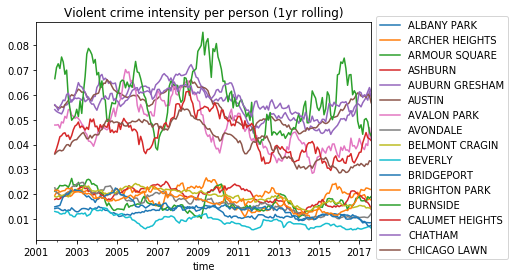

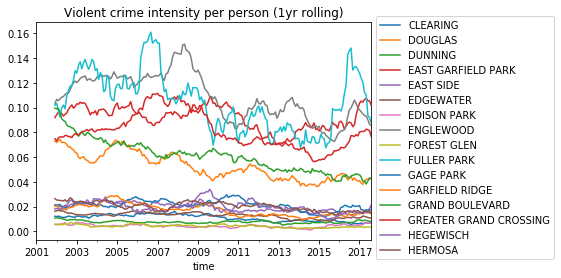

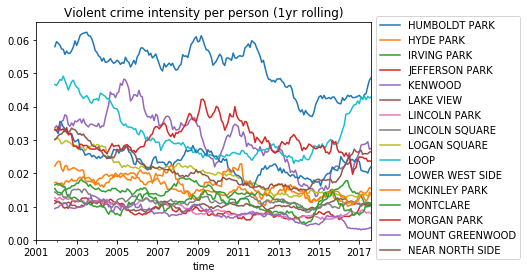

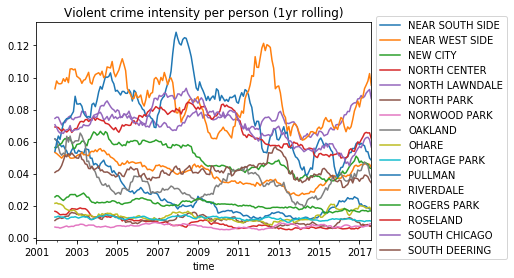

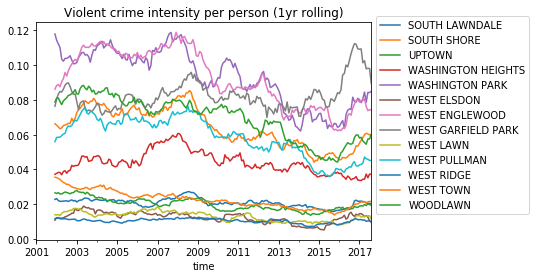

In [38]:
category = 'Violent'

crime_category_time = neighb_crimes_percapita.sum(axis = 1, level = 0)[[category]]\
    .reset_index()\
    .pivot(index = 'time', columns = 'neighborhood', values = category)

multi_timeseries_explore_plot(crime_category_time, title = category + ' crime intensity per person (1yr rolling)')

plt.show()

### City of Chicago Crime Intensity

A similar analysis to the above allows us to produce the mean crime severity throughout the entire city through time

In [39]:
chicago_crimes_intermediate =\
    individual_crimes.groupby(['crime_description', 'crime_type', 'time'])[['severity']]\
    .sum().rename(columns = {'sum' : 'severity'})

In [40]:
chicago_crime_intensity = chicago_crimes_intermediate\
    .pivot_table(index = 'time', 
                 columns = ['crime_type', 'crime_description'],
                 values = 'severity')\
    .fillna(0)\
    .rolling(12).sum()

In [41]:
chicago_crime_intensity_ref = pd.DataFrame(index = chicago_crime_intensity.index)\
    .join(city_population.set_index(['time'])[['population']])['population']

chicago_crimes_percapita = chicago_crime_intensity.copy().div(chicago_crime_intensity_ref, axis = 0)

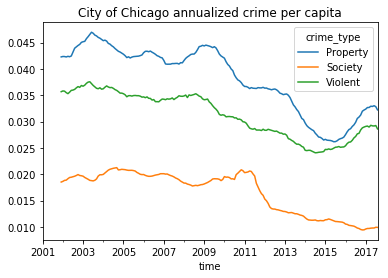

In [42]:
chicago_crimes_percapita.sum(level=0, axis=1).plot(title = 'City of Chicago annualized crime per capita')

plt.show()

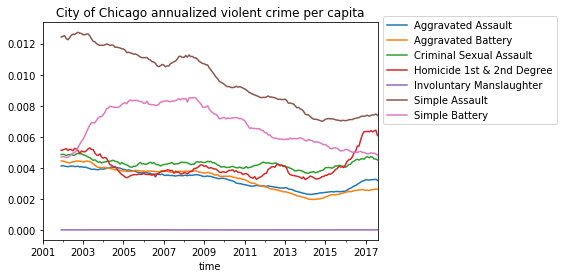

In [43]:
chicago_crimes_percapita['Violent']\
    .plot(title = 'City of Chicago annualized violent crime per capita')\
    .legend(bbox_to_anchor=(1, 1.05))
plt.show()

### Race crime share

We can also look at density of race in each neighborhood to get a proxy of how crime affects various races

We do this by taking the neighborhood per capita crime, which is the approximately same at the race level within the neighborhood, and doing a race-weighted-average across the city.

What this means is we weight crime by the race populations in the neighborhood compared to the total race population in the city.

In [44]:
neighb_population_pct_total = pd.merge(
    pd.melt(neighb_population.drop('population', axis = 1), 
            id_vars = ['neighborhood', 'time'], 
            var_name = 'race',
            value_name = 'neighb_pop').reset_index(),
    pd.melt(city_population.drop('population', axis = 1), 
            id_vars = ['time'], 
            var_name = 'race',
            value_name = 'city_pop').reset_index(),
    on = ['time', 'race']
)
neighb_population_pct_total['city_race_pct'] = neighb_population_pct_total['neighb_pop'] / neighb_population_pct_total['city_pop']
neighb_population_pct_total = neighb_population_pct_total[['neighborhood', 'time', 'race', 'city_race_pct']]
neighb_population_pct_total = neighb_population_pct_total.sort_values(['neighborhood', 'time']).reset_index(drop = True)

In [45]:
crimes_per_capita_melted = \
    pd.melt(neighb_crimes_percapita.reset_index(), id_vars = ['neighborhood', 'time'], value_name = 'severity')

crimes_per_capita_race_intermediate = pd.merge(crimes_per_capita_melted, 
                                               neighb_population_pct_total, 
                                               on = ['neighborhood', 'time'])
crimes_per_capita_race_intermediate['weighted_severity'] = \
    crimes_per_capita_race_intermediate['severity'] * crimes_per_capita_race_intermediate['city_race_pct']
    
crimes_per_capita_race = crimes_per_capita_race_intermediate\
    .pivot_table(index = ['race', 'time'], 
                 columns = ['crime_type', 'crime_description'], 
                 values = ['weighted_severity'], aggfunc = np.sum)['weighted_severity']

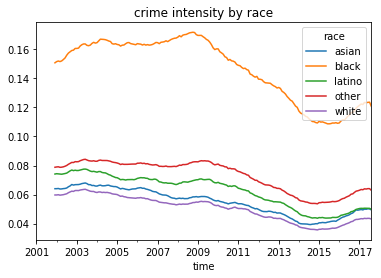

In [46]:
race_over_time = crimes_per_capita_race.sum(axis = 1)\
    .reset_index()\
    .pivot(index = 'time', columns = 'race')[0]

race_over_time.plot(title = 'crime intensity by race')

plt.show()

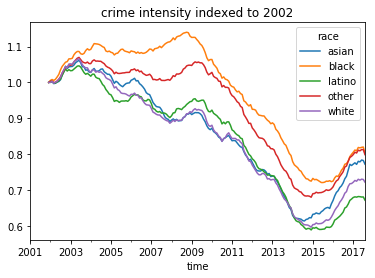

In [47]:
race_over_time_indexed = race_over_time.div(race_over_time.loc[race_over_time.first_valid_index()], axis = 1)

race_over_time_indexed.plot(title = 'crime intensity indexed to 2002')

plt.show()

### City crime Gini coefficients

In [48]:
crime_types_for_gini = np.append(neighb_crimes_percapita.columns.levels[0].values, 'Total')

crimes_for_gini_prep = neighb_crimes_percapita.sum(axis = 1, level = 0)
crimes_for_gini_prep['Total'] = crimes_for_gini_prep.sum(axis = 1)
crimes_for_gini_prep['pop_weight'] = neighb_crimes_population_ref
crimes_for_gini_prep = crimes_for_gini_prep.reset_index().pivot(index = 'time', columns = 'neighborhood')

In [49]:
crime_gini_timeseries = pd.DataFrame(index = crimes_for_gini_prep.index)

for ct in crime_types_for_gini:
    crime_gini_timeseries[ct] = \
        crimes_for_gini_prep.apply(lambda row: gini(row[ct].values, row['pop_weight'].values), axis = 1)

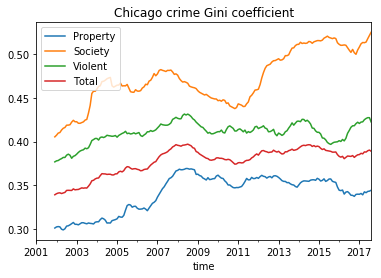

In [50]:
crime_gini_timeseries.plot(title = 'Chicago crime Gini coefficient')
plt.show()

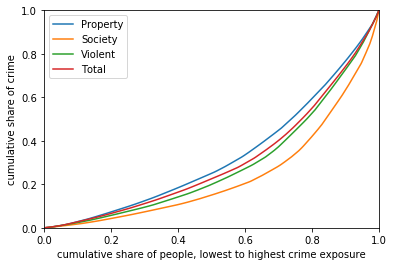

In [51]:
for ct in crime_types_for_gini:
    last_idx = crimes_for_gini_prep.index[-1]
    x, y = zip(*get_lorenz_curve(crimes_for_gini_prep.loc[last_idx][ct], crimes_for_gini_prep.loc[last_idx]['pop_weight']))
    plt.plot(x, y, label = ct)
plt.xlabel('cumulative share of people, lowest to highest crime exposure')
plt.ylabel('cumulative share of crime')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.show()

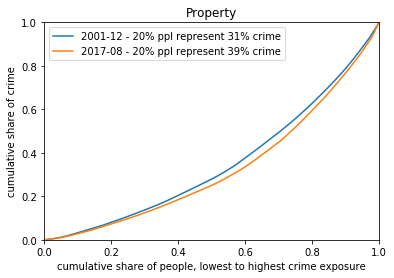

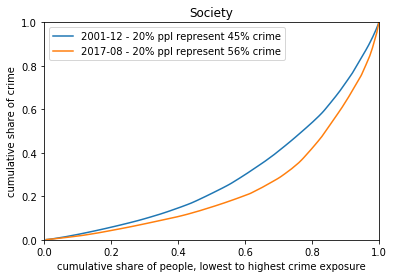

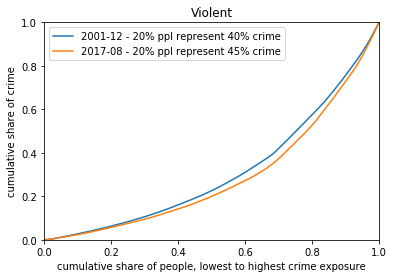

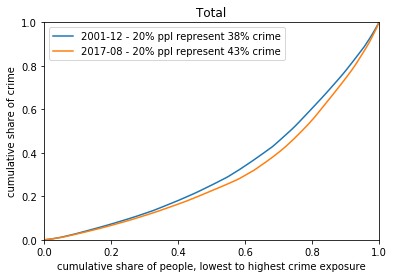

In [52]:
top_pct_consider = 0.2
first_idx = crimes_for_gini_prep.index[~crimes_for_gini_prep['Total'].sum(axis = 1).isnull()][0]
last_idx = crimes_for_gini_prep.index[-1]
for ct in crime_types_for_gini:
    plt.xlabel('cumulative share of people, lowest to highest crime exposure')
    plt.ylabel('cumulative share of crime')
    plt.title(ct)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    tmp_lorenz_curve = get_lorenz_curve(crimes_for_gini_prep.loc[first_idx][ct], crimes_for_gini_prep.loc[first_idx]['pop_weight'])
    top_crime_initial = pct_of_crime_in_top_pct_ppl(tmp_lorenz_curve, top_pct_consider)
    x, y = zip(*tmp_lorenz_curve)
    plt.plot(x, y, label = ct)
    tmp_lorenz_curve = get_lorenz_curve(crimes_for_gini_prep.loc[last_idx][ct], crimes_for_gini_prep.loc[last_idx]['pop_weight'])
    top_crime_final = pct_of_crime_in_top_pct_ppl(tmp_lorenz_curve, top_pct_consider)
    x, y = zip(*tmp_lorenz_curve)
    plt.plot(x, y, label = ct)
    plt.legend([str(first_idx) + ' - ' + str(int(top_pct_consider*100)) + \
                  '% ppl represent ' + str(int(100*top_crime_initial)) + '% crime',
                str(last_idx) + ' - ' + str(int(top_pct_consider*100)) + \
                  '% ppl represent ' + str(int(100*top_crime_final)) + '% crime'])
    plt.show()

## A look at crime and income

How have crime intensity and incomes moved over time and is there a relation between these? While overall crime intensity per person has come down throughout the city, there are cases where it was flat or increased, contributing to the increase in crime inequality (i.e. overall some of the city has gotten better, but some has stayed the same). How does this look when accounting for income?

The two time points we'll use for reference are 1/2002 and 1/2017, and we'll take a look at how things have shifted during this 15 year period.

In [53]:
crimes_vs_income_time = pd.DataFrame({ 'crime_intensity' : neighb_crimes_percapita.sum(axis = 1).copy()})
crimes_vs_income_time = crimes_vs_income_time\
    .join(neighb_incomes.set_index(['neighborhood', 'time'])['median_income'])

In [54]:
history_point = pd.Period('2002-01', 'M')
spot_point = pd.Period('2017-01', 'M')

crimes_vs_income = crimes_vs_income_time[
    np.isin(crimes_vs_income_time.reset_index()['time'].values, (history_point, spot_point))
].reset_index().pivot_table(index = 'neighborhood', columns = 'time', values = ['crime_intensity', 'median_income'])

for col in crimes_vs_income.columns.levels[0]:
    crimes_vs_income[col, 'difference'] = crimes_vs_income[col, spot_point] - crimes_vs_income[col, history_point]
    
crimes_vs_income = crimes_vs_income.reorder_levels([1, 0], axis = 1)

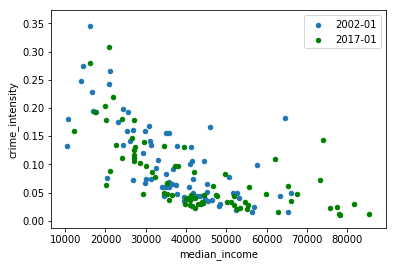

In [55]:
ax = crimes_vs_income[history_point].plot.scatter('median_income', 'crime_intensity', label = history_point)
crimes_vs_income[spot_point].plot.scatter('median_income', 'crime_intensity', label = spot_point, color = 'g', ax = ax)

plt.show()

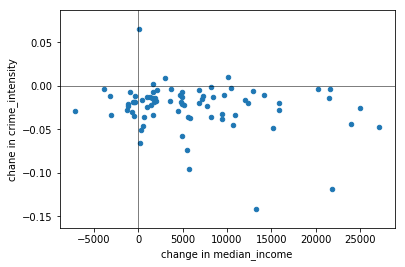

In [56]:
crimes_vs_income['difference'].plot.scatter('median_income', 'crime_intensity')
plt.xlabel('change in median_income')
plt.ylabel('chane in crime_intensity')
plt.axhline(0, color = 'k', linewidth = 0.5)
plt.axvline(0, color = 'k', linewidth = 0.5)
plt.show()

## Outputs

Finally we will save key outputs the analyses above for d3 visualization upstream

For the city-wide data, we store monthly timeseries aggregates

For the neighborhood information, we store a geojson whose attributes contain things like timeseries

We additionally produce "other" outputs:
* Crime severity 
* Gini curve

In [75]:
chicago_crimes_percapita_crimetype_out = chicago_crimes_percapita.sum(axis = 1, level = 0).reset_index()
chicago_crimes_percapita_crimetype_out.to_csv('./microblog/app/static/data/chicago_crimes_percapita_crimetype.csv', 
                                              index=False)

In [76]:
chicago_crimes_percapita_crimelevel_out = \
    pd.melt(chicago_crimes_percapita.reset_index(), id_vars=['time'], value_name='crime_intensity')
chicago_crimes_percapita_crimelevel_out.to_csv('./microblog/app/static/data/chicago_crimes_percapita_crimelevel.csv',
                                               index = False)